In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q catboost optuna

     |████████████████████████████████| 76.6 MB 1.1 MB/s 
     |████████████████████████████████| 348 kB 69.7 MB/s 
     |████████████████████████████████| 209 kB 67.2 MB/s 
     |████████████████████████████████| 81 kB 10.5 MB/s 
     |████████████████████████████████| 78 kB 9.3 MB/s 
     |████████████████████████████████| 147 kB 77.7 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
     |████████████████████████████████| 112 kB 66.8 MB/s 


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import AdamW, lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss
from sklearn.multioutput import MultiOutputClassifier
import optuna

In [4]:
BASE_MODEL_PATH = '/content/drive/MyDrive/ITMO Master/datasets/ml-industry/models/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load All Logits

In [5]:
# train logits
with open(BASE_MODEL_PATH + 'vit-logits/train-logits.pkl', 'rb') as r:
    img_train_logits = pickle.load(r)

with open(BASE_MODEL_PATH + 'title-bart-logits/train-logits.pkl', 'rb') as r:
    title_train_logits = pickle.load(r)

with open(BASE_MODEL_PATH + 'desc-bart-logits/train-logits.pkl', 'rb') as r:
    desc_train_logits = pickle.load(r)

train_logits = torch.cat([
    img_train_logits, 
    title_train_logits, 
    desc_train_logits], dim=1)
train_logits.shape

torch.Size([5119, 72])

In [6]:
img_train_logits.shape, title_train_logits.shape, desc_train_logits.shape

(torch.Size([5119, 24]), torch.Size([5119, 24]), torch.Size([5119, 24]))

In [7]:
# # valid logits
# with open(BASE_MODEL_PATH + 'vit-logits/val-logits.pkl', 'rb') as r:
#     img_valid_logits = pickle.load(r)

# with open(BASE_MODEL_PATH + 'title-bart-logits/valid-logits.pkl', 'rb') as r:
#     title_valid_logits = pickle.load(r)

# with open(BASE_MODEL_PATH + 'desc-bart-logits/valid-logits.pkl', 'rb') as r:
#     desc_valid_logits = pickle.load(r)

# valid_logits = torch.cat([img_valid_logits, title_valid_logits, desc_valid_logits], dim=1)
# valid_logits.shape

In [8]:
# test logits
with open(BASE_MODEL_PATH + 'vit-logits/test-logits.pkl', 'rb') as r:
    img_test_logits = pickle.load(r)

with open(BASE_MODEL_PATH + 'title-bart-logits/test-logits.pkl', 'rb') as r:
    title_test_logits = pickle.load(r)

with open(BASE_MODEL_PATH + 'desc-bart-logits/test-logits.pkl', 'rb') as r:
    desc_test_logits = pickle.load(r)

test_logits = torch.cat([
    img_test_logits, 
    title_test_logits, 
    desc_test_logits], dim=1)
test_logits.shape

torch.Size([1280, 72])

In [9]:
# labels
with open('/content/drive/MyDrive/ITMO Master/datasets/ml-industry/models/train-labels.pkl', 'rb') as r:
    train_labels = pickle.load(r)

# with open('/content/drive/MyDrive/ITMO Master/datasets/ml-industry/models/valid-labels.pkl', 'rb') as r:
#     valid_labels = pickle.load(r)

with open('/content/drive/MyDrive/ITMO Master/datasets/ml-industry/models/test-labels.pkl', 'rb') as r:
    test_labels = pickle.load(r)

### XGBoost

In [10]:
# convert logits and labels
X_train_np = train_logits.numpy()
# X_valid_np = valid_logits.numpy()
X_test_np = test_logits.numpy()
# labels
y_train_np = train_labels.numpy()
# y_valid_np = valid_labels.numpy()
y_test_np = test_labels.numpy()

In [11]:
def objective(trial):
    params = {
        # 'tree_method': 'gpu_hist',
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1),
        'n_estimators': 100,
        'seed': 42,
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7, 10, 12, 13, 15])
    }

    model = MultiOutputClassifier(XGBClassifier(**params))
    model.fit(X_train_np, y_train_np)

    preds = model.predict(X_test_np)
    # model.__del__()

    f1 = f1_score(y_test_np, preds, average='micro')
    # roc_auc = roc_auc_score(y_test_np, preds, average='micro')

    return f1

In [12]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_jobs=-1, n_trials=15)

[I 2022-11-25 20:25:55,491] A new study created in memory with name: no-name-4e9879aa-b7cb-4be7-9d94-9c34d99675a0
[I 2022-11-25 20:28:15,022] Trial 0 finished with value: 0.6464817320703654 and parameters: {'lambda': 7.408307998091976, 'subsample': 0.3295935044012618, 'learning_rate': 0.029582467090952774, 'max_depth': 15}. Best is trial 0 with value: 0.6464817320703654.
[I 2022-11-25 20:29:30,106] Trial 1 finished with value: 0.6430748391466306 and parameters: {'lambda': 7.323175614380114, 'subsample': 0.8315420344288234, 'learning_rate': 0.059691243561044875, 'max_depth': 10}. Best is trial 0 with value: 0.6464817320703654.
[I 2022-11-25 20:30:19,767] Trial 2 finished with value: 0.6441372247823861 and parameters: {'lambda': 8.148036578784767, 'subsample': 0.37421670955095754, 'learning_rate': 0.08069663049258025, 'max_depth': 13}. Best is trial 0 with value: 0.6464817320703654.
[I 2022-11-25 20:31:43,293] Trial 3 finished with value: 0.6424077537833701 and parameters: {'lambda': 8.8

In [13]:
print(study.best_value)
study.best_params

0.6468413978494624


{'lambda': 5.014063188111611,
 'subsample': 0.8113588583580158,
 'learning_rate': 0.01331524020038881,
 'max_depth': 7}

In [11]:
best_params = {'lambda': 5.014063188111611,
               'subsample': 0.8113588583580158,
               'learning_rate': 0.01331524020038881,
               'max_depth': 7}


In [15]:
# best_xgb = MultiOutputClassifier(XGBClassifier(n_estimators=100, 
#                                                seed=42, 
#                                                lambda=5.014063188111611,
#                                                subsample=0.8113588583580158,
#                                                learning_rate=0.01331524020038881,
#                                                max_depth=7))

classifier = MultiOutputClassifier(XGBClassifier(n_estimators=100, seed=42, tree_hist='gpu'))
classifier.estimator.set_params(**best_params)

XGBClassifier(lambda=5.014063188111611, learning_rate=0.01331524020038881,
              max_depth=7, seed=42, subsample=0.8113588583580158,
              tree_hist='gpu')

In [16]:
classifier.fit(X_train_np, y_train_np)

MultiOutputClassifier(estimator=XGBClassifier(lambda=5.014063188111611,
                                              learning_rate=0.01331524020038881,
                                              max_depth=7, seed=42,
                                              subsample=0.8113588583580158,
                                              tree_hist='gpu'))

In [17]:
preds = classifier.predict(X_test_np)

In [25]:
print(f'Accuracy: {accuracy_score(y_test_np, preds)}')
print(f'F1 Score: {f1_score(y_test_np, preds, average="micro")}')
print(f'ROC-AUC: {roc_auc_score(y_test_np, preds, average="micro")}')

Accuracy: 0.1984375
F1 Score: 0.6468413978494624
ROC-AUC: 0.7866766100028966


In [26]:
print(classification_report(y_test_np, preds))

              precision    recall  f1-score   support

           0       0.65      0.64      0.64       237
           1       0.67      0.53      0.59       222
           2       0.81      0.82      0.82       179
           3       0.64      0.41      0.50        68
           4       0.72      0.65      0.68       376
           5       0.74      0.73      0.74       235
           6       0.78      0.53      0.63       100
           7       0.76      0.82      0.79       690
           8       0.50      0.35      0.41       106
           9       0.48      0.34      0.40        91
          10       0.00      0.00      0.00         2
          11       0.61      0.49      0.54       115
          12       0.61      0.39      0.48        77
          13       0.76      0.55      0.64        87
          14       0.39      0.21      0.27        34
          15       0.47      0.35      0.40       136
          16       0.60      0.44      0.50       131
          17       0.53    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
cm = multilabel_confusion_matrix(y_test_np, preds)
cm.shape

(24, 2, 2)

In [54]:
df = pd.read_csv('/content/drive/MyDrive/ITMO Master/datasets/ml-industry/task2_1/compiled.csv')
labels = df.genre.unique()
label2id = {v: k for k, v in enumerate(labels)}
id2label = {k: v for k, v in enumerate(labels)}

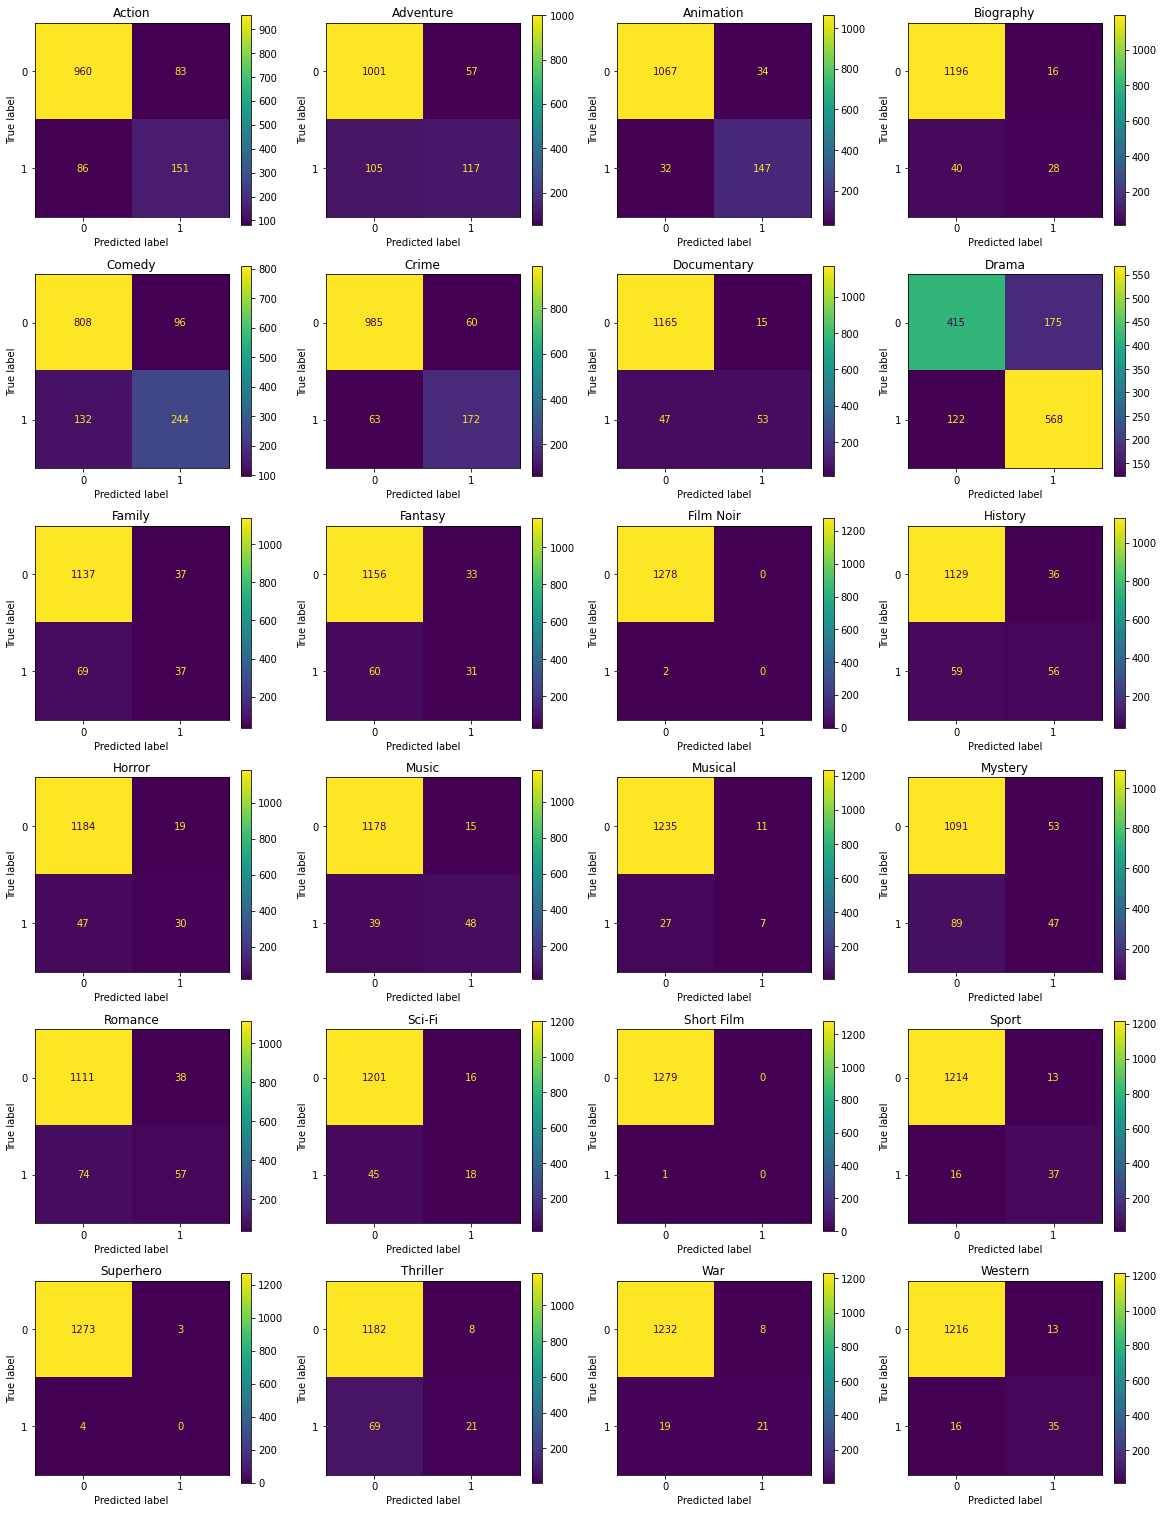

In [57]:
pointer = 0

fig, ax = plt.subplots(6, 4, figsize=(20,27))
for i in range(6):
    for j in range(4):
        cm_display = ConfusionMatrixDisplay(cm[pointer])
        cm_display.plot(ax=ax[i,j])
        ax[i, j].set_title(labels[pointer])
        pointer += 1
plt.show()